In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 100
import seaborn as sns
plt.style.use('presentation.mplstyle')
import logging

# Get the logger for 'fontTools'
font_tools_logger = logging.getLogger('fontTools')

# Set the logging level to WARNING, which ignores DEBUG and INFO messages
font_tools_logger.setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\Fig2"

In [3]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[0]
path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")
spatial_temporal_graph,folders = load(path_tot)

In [4]:
spatial_temporal_graph_sub = create_subgraph_by_attribute(spatial_temporal_graph,"post_hyperedge_activation",39)

In [5]:
def merge_hyperedge(hyperdege0,hyperedge1,graph):
    edges = graph.get_hyperedge_edges(hyperedge1)
    edges_new = merge(edges, graph)
    for u,v in edges_new:
        graph[u][v]["hyperedge"] = hyperdege0
# #441
        
merge_hyperedge(3169,3728,spatial_temporal_graph)
merge_hyperedge(3169,3874,spatial_temporal_graph)
#310

# merge_hyperedge(335,443,spatial_temporal_graph)
# merge_hyperedge(31,133,spatial_temporal_graph)
# merge_hyperedge(242,171,spatial_temporal_graph)
# merge_hyperedge(1586,673,spatial_temporal_graph)
# merge_hyperedge(1586,780,spatial_temporal_graph)
# merge_hyperedge(167,1583,spatial_temporal_graph)
# merge_hyperedge(167,640,spatial_temporal_graph)

In [6]:
exp = make_exp(spatial_temporal_graph_sub,folders)
weights = {(begin, end): LineString(data['pixel_list']).length * 1.725 for begin, end, data in
           spatial_temporal_graph_sub.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph_sub, weights, "length")
weights = {(begin, end): data["37"]['speed_heaton'] if 'speed_heaton' in data["37"] else 0 for begin, end, data in
           spatial_temporal_graph_sub.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph_sub, weights, "speed_heaton_42")
weights = {(begin, end): data['pixel_list'][0][0] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "x")
weights = {(begin, end): data['pixel_list'][0][1] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "y")

In [7]:
refs = {
    "310_20230830": {
        "20230901_Plate310": "20230901_0719_Plate06",
        "20230902_Plate310": "20230902_1343_Plate07",
        "20230903_Plate310": "20230903_1143_Plate07",
        "20230904_Plate310": "20230904_0942_Plate07",
        "20230905_Plate310": "20230905_1345_Plate07",
        # "20230906_Plate310" : "20230906_1220_Plate07",
    },
    "441_20230807": {
        "20230810_Plate441": "20230810_1005_Plate14",
        "20230811_Plate441": "20230811_1605_Plate14",
        "20230812_Plate441": "20230812_1006_Plate14",
        "20230813_Plate441": "20230813_1618_Plate14",
    },
    "449_20230807": {
        "20230813_Plate449": "20230813_1606_Plate10",
        "20230814_Plate449": "20230814_1019_Plate10",
        "20230815_Plate449": "20230815_1021_Plate10",
        "20230816_Plate449": "20230816_1027_Plate10",
        # "20230818_Plate449": "20230818_1107_Plate10",
    },
}
indexes = refs[plate_id]

In [8]:
import matplotlib.patches as patches
def show_region(region,ax,downsizing = 5):
    adjusted_region = [[coord / downsizing for coord in point] for point in region]

    # Display the image (assuming 'image' is your loaded image)
    # ax.imshow(image)

    # Calculate rectangle parameters
    x0, y0 = adjusted_region[0]  # Lower-left corner
    x1, y1 = adjusted_region[1]  # Upper-right corner
    print(x0,y0,x1,y1)
    # Create a rectangle patch
    rect = patches.Rectangle((y0, x0), y1 - y0, x1 - x0, linewidth=2, edgecolor='g', facecolor='none',alpha = 0.8)
    ax.add_patch(rect)

In [9]:
def check_has_video(edge,graph):
    for i in range(graph.max_age+1):
        if 'video_edge' in graph[edge[0]][edge[1]][str(i)]:
            return(True)
    return(False)

In [10]:
edges_info = [edge for edge in spatial_temporal_graph.edges() if check_has_video(edge,spatial_temporal_graph)]

In [11]:
all_infos = pd.DataFrame()
attribute_list = ["QBC_tot","QBC_net","water_flux","speed_backflow","speed_heaton","water_flux_heaton","speed_backflow2"]
static_atrribute = ["hyperedge",
                    "abcisse",
                    "x",
                    "y",
                   ]
edge_specific_attribute = ["ordered_mapping","R","mapping"]
iss = []
for edge in edges_info:
    for i in range(spatial_temporal_graph.max_age+1):
         if 'video_edge' in spatial_temporal_graph[edge[0]][edge[1]][str(i)]:
            if i not in iss:
                iss.append(i)
                # print(i,spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'])
            network_edge_infos = spatial_temporal_graph[edge[0]][edge[1]]
            for j in range(len(network_edge_infos[str(i)]['video_edge'])):
                edge_obj = spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'][j]
                x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
                x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
                for attribute in attribute_list:
                    if attribute in network_edge_infos[str(i)]:
                        edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute]
                for attribute in edge_specific_attribute:
                    edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute][j]
                for attribute in static_atrribute:
                    if attribute in network_edge_infos:
                        edge_obj.mean_data[attribute]=network_edge_infos[attribute]
                edge_data_csv = edge_obj.mean_data
                edge_data_csv['folder'] = folders["folder"].iloc[i]
                edge_data_csv['edge_network'] = edge

                if "water_flux" in edge_data_csv.keys():
                    edge_data_csv['ordered_final'] = -edge_data_csv['ordered_mapping']

                    edge_data_csv['ordered_final'] *= (1-2*(edge[0]>edge[1]))
                    edge_data_csv['ordered_final'] *= (1-2*(x1>x2))
                    # edge_data_csv['ordered_final'] *= (1-2*(edge_data_csv['water_flux']>0))

                edge_data_csv = pd.DataFrame(edge_data_csv).transpose()
                all_infos = pd.concat([all_infos,edge_data_csv])
    # break

In [12]:
# region = [[3000*5,5000*5],[5250*5,7500*5]]
minx = 1000*5
maxx = 25000
miny = 6000*5

maxy = 44000
list_video = [114,88,70]
window_sizex = 3000*1.725/25*10
window_sizey = 4096*1.725/25*10
regions = []
select = all_infos[all_infos['folder']=='20230812_1006_Plate14']
select = select[select["video_int"].isin(list_video)]
for video_int in list_video:
    select_video = select[select["video_int"]==video_int].iloc[0]
    x,y = select_video["x"]/1.725,select_video["y"]/1.725
    beginx = x-window_sizex-minx
    endx = x+window_sizex-minx
    beginy = y-window_sizey-miny
    endy = y+window_sizey-miny
    regions.append([[beginx,beginy],[endx,endy]])


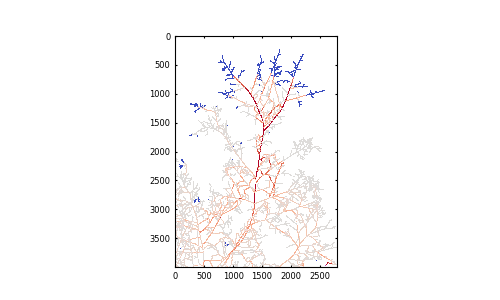

2569.30570220725 801.474945495557 3397.30570220725 1931.9709454955562
1936.2473550362715 752.2191937791183 2764.2473550362715 1882.7151937791175
1090.289662367945 958.813923177727 1918.289662367945 2089.309923177726


In [13]:
mpl.rcParams["figure.dpi"] = 100


exp = make_exp(spatial_temporal_graph_sub,folders)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 0.02
vmin = -0.02
t=0
def color_edge(edge):
    if spatial_temporal_graph_sub[edge.begin.label][edge.end.label]['post_hyperedge_activation']>=37:
        return(-vmax)
    else:
        return(np.abs(spatial_temporal_graph_sub[edge.begin.label][edge.end.label]["speed_heaton_42"])*C_factor_flux)

region = [[minx,miny],[maxx,maxy]]
# region = [[0*5,6000*5],[25000,44000]]

fig, ax,f = plot_edge_color_value_3(
    exp,
    t,
    lambda edge : color_edge(edge),
    # lambda edge : color_edge(edge),
    
    cmap=cm.get_cmap("coolwarm", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=15,
    figsize=(5, 3),
    alpha = 1,
    region = region
)

for region in regions:
    show_region(region,ax)
plt.xticks([])  # Removes 
plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels
plt.savefig(
    os.path.join(path_figure, f"lipid_density.pdf"),
    transparent=True,
    bbox_inches="tight",
)

In [14]:
minx = 0*5
maxx = 25000
miny = 6000*5

maxy = 44000
list_video = [114,88,70]
window_sizex = 3000*1.725/25*10
window_sizey = 4096*1.725/25*10
regions = []
select = all_infos[all_infos['folder']=='20230812_1006_Plate14']
select = select[select["video_int"].isin(list_video)]
for video_int in list_video:
    select_video = select[select["video_int"]==video_int].iloc[0]
    x,y = select_video["x"]/1.725,select_video["y"]/1.725
    beginx = x-window_sizex
    endx = x+window_sizex
    beginy = y-window_sizey
    endy = y+window_sizey
    regions.append([[beginx,beginy],[endx,endy]])


In [15]:
def plot_arrows_along_edge(ax, begin, end, color, spacing=60):
    # Calculate the vector and its magnitude
    vector = end - begin
    distance = np.linalg.norm(vector)
    unit_vector = vector / distance

    # Calculate the number of arrows to create based on the spacing
    num_arrows = int(distance / spacing)
    if num_arrows<2:
        spacing= distance/2
        num_arrows = 1
    # Plot each arrow along the edge
    for i in range(1, num_arrows + 1):
        point = begin + unit_vector * (i * spacing)
        ax.annotate('', xytext=(point[1], point[0]), xy=(point[1] + unit_vector[1], point[0] + unit_vector[0]),
                    arrowprops=dict(arrowstyle="->,head_length=0.2,head_width=0.1", color=color))

In [16]:
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

t=0
downsizing = 5
def plot_region(region):
    fig, ax,f = plot_edge_color_value_3(
        exp,
        t,
        lambda edge : color_edge(edge),
        cmap=cm.get_cmap("coolwarm", 100),
        plot_cmap=True,
        show_background=False,
        dilation=10,
        figsize=(3, 2),
        alpha = 1,
        downsizing = downsizing,
        region = region,
        v_min = -vmax,
        v_max = vmax
    )
    edges_network = get_all_edges(exp,t)
    for edge in edges_network:
        pixels = edge.pixel_list(t)

        if is_in_bounding_box(pixels[0], region) or is_in_bounding_box(pixels[-1], region):
            if len(pixels) > 20:
                begin_arrow = np.array(f(pixels[20]))
                end_arrow = np.array(f(pixels[-20]))
                print
                if np.abs(edge.get_attribute("speed_heaton_42", t))>0:
                    relative_flux = edge.get_attribute("speed_heaton_42", t)
                    orientation =  (2 * (relative_flux > 0)-1)
                    orientation *= (2 * (edge.begin.label > edge.end.label)-1)
                    color = 'green'
                    edge_width = 1  # Adjust the width as needed
                    if orientation<0:
                        begin_arrow,end_arrow = end_arrow,begin_arrow
                    # if abs(relative_flux) > 0.5:
                    plot_arrows_along_edge(ax, begin_arrow, end_arrow, color)
    plt.xticks([])  # Removes 
    plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels

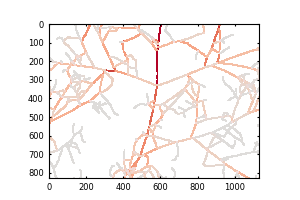

C:\Users\coren\AppData\Local\Temp\ipykernel_30616\3332054734.py:5: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / distance


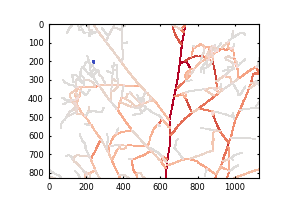

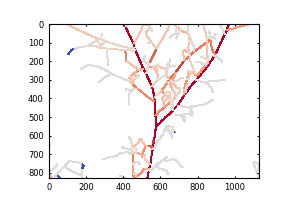

In [17]:
for i,region in enumerate(regions):
    plot_region(region)
    plt.savefig(
    os.path.join(path_figure, f"region{i}.pdf"),
    transparent=True,
    bbox_inches="tight",

    )
    # break

In [18]:
all_infos = pd.DataFrame()
for plate_id in plates:
    path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")
    spatial_temporal_graph,folders = load(path_tot)
    edges_info = [edge for edge in spatial_temporal_graph.edges() if check_has_video(edge,spatial_temporal_graph)]
    attribute_list = ["QBC_tot","QBC_net","water_flux","speed_backflow","speed_heaton","water_flux_heaton","speed_backflow2"]
    static_atrribute = ["hyperedge",
                        # "abcisse",
                        # "x",
                        # "y",
                       ]
    edge_specific_attribute = ["ordered_mapping","R","mapping"]
    iss = []
    for edge in edges_info:
        for i in range(spatial_temporal_graph.max_age+1):
             if 'video_edge' in spatial_temporal_graph[edge[0]][edge[1]][str(i)]:
                if i not in iss:
                    iss.append(i)
                    # print(i,spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'])
                network_edge_infos = spatial_temporal_graph[edge[0]][edge[1]]
                for j in range(len(network_edge_infos[str(i)]['video_edge'])):
                    edge_obj = spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'][j]
                    x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
                    x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
                    for attribute in attribute_list:
                        if attribute in network_edge_infos[str(i)]:
                            edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute]
                    for attribute in edge_specific_attribute:
                        edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute][j]
                    for attribute in static_atrribute:
                        if attribute in network_edge_infos:
                            edge_obj.mean_data[attribute]=network_edge_infos[attribute]
                    edge_data_csv = edge_obj.mean_data
                    edge_data_csv['folder'] = folders["folder"].iloc[i]
                    edge_data_csv['edge_network'] = edge
                    edge_data_csv['plate_id'] = plate_id

                    if "water_flux" in edge_data_csv.keys():
                        edge_data_csv['ordered_final'] = -edge_data_csv['ordered_mapping']

                        edge_data_csv['ordered_final'] *= (1-2*(edge[0]>edge[1]))
                        edge_data_csv['ordered_final'] *= (1-2*(x1>x2))
                        # edge_data_csv['ordered_final'] *= (1-2*(edge_data_csv['water_flux']>0))

                    edge_data_csv = pd.DataFrame(edge_data_csv).transpose()
                    all_infos = pd.concat([all_infos,edge_data_csv])
    # break

In [19]:
all_infos['relative_flux'] = (all_infos["flux_left"]+all_infos['flux_right'])/(all_infos["flux_left"]-all_infos['flux_right'])*2

In [20]:
all_infos["ordered_heaton"] = all_infos['ordered_final']*(1-2*(all_infos['speed_heaton']>0))
all_infos['growth_flux']= all_infos["ordered_heaton"]*np.abs(all_infos['speed_heaton'])*C_factor
all_infos['aligned']= np.sign((all_infos["relative_flux"]*all_infos["growth_flux"]).astype(float))

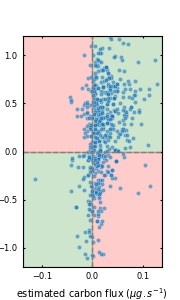

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sample data setup
# Assuming 'select' is your DataFrame already filtered based on previous conditions.
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="F"]
select = select[select['aligned']!=0]
select = select[select['plate_id'].isin(['441_20230807', '449_20230807'])]
# Proportion calculation for 'aligned' values -1 and 1
aligned_counts = select['aligned'].value_counts(normalize=True).reindex([-1, 1], fill_value=0) * 100  # Multiply by 100 for percentage

# Plotting
fig, ax1 = plt.subplots(figsize = (1.8,3))
fig.subplots_adjust(hspace=0.5)  # Increase horizontal space between the plots
# Color the quadrants
# Define limits for clarity and reusability
xlim = (-0.6 * C_factor, 0.6 * C_factor)  # Assuming C_factor is defined elsewhere
ylim = (-1.2, 1.2)

# Color the quadrants using fill_between and fill_betweenx
ax1.fill_betweenx(y=[ylim[0], 0], x1=xlim[0], x2=0, color='green', alpha=0.2)
ax1.fill_betweenx(y=[0, ylim[1]], x1=0, x2=xlim[1], color='green', alpha=0.2)
ax1.fill_betweenx(y=[ylim[0], 0], x1=0, x2=xlim[1], color='red', alpha=0.2)
ax1.fill_betweenx(y=[0, ylim[1]], x1=xlim[0], x2=0, color='red', alpha=0.2)

# Scatter plot on the first subplot
sns.scatterplot(data=select, x="growth_flux", y="relative_flux", s=10, alpha=0.6, ax=ax1)
ax1.axhline(y=0, color='gray', linestyle='--')
ax1.axvline(x=0, color='gray', linestyle='--')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel("estimated carbon flux ($\mu g. s^{-1}$)")
ax1.set_ylabel("relative fluorescence flux ($\mu g. s^{-1}$)")

# # Horizontal bar chart on the second subplot
# # Calculate the position for the green bar
# left_for_green = [aligned_counts[-1]]  # Start green bar where red bar ends

# ax2.barh(y=['aligned'], width=aligned_counts[-1], color='red', label='-1')
# ax2.barh(y=['aligned'], width=aligned_counts[1], left=left_for_green, color='green', label='1')
# ax2.set_xlabel('Percentage')
# ax2.set_xlim(0, 100)  # Set x-axis limits from 0 to 100 for percentages

# Adjust layout and save
# plt.tight_layout()

# Example of how to save the figure if needed
plt.savefig(
    os.path.join(path_figure, "flux_distrib.pdf"),
    transparent=True,
    bbox_inches="tight",
)


In [41]:
all_infos['relative_flux'] = all_infos['relative_flux'].astype(float)
all_infos['growth_flux'] = all_infos['growth_flux'].astype(float)

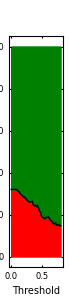

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'all_infos' is your DataFrame and the filtering conditions are set as before.
filtered = all_infos[(all_infos['mapping'] < 10) & 
                     (all_infos['coverage_tot'] >= 0.1) & 
                     (all_infos['mode'] == "F") & 
                     (all_infos['aligned'] != 0) & 
                     (all_infos['plate_id'].isin(['441_20230807', '449_20230807']))]

# Define thresholds
thresholds = np.linspace(0, 0.8, 50)  # Finer threshold steps for smoother curve

# Prepare to collect proportions for `aligned == 1`
proportions = []

# Loop through each threshold to compute proportion of `aligned == 1`
for thresh in thresholds:
    current_select = filtered[np.sqrt((filtered['growth_flux']/0.1)**2+(filtered['relative_flux'])**2) >= thresh]
    if not current_select.empty:
        proportion = (current_select['aligned'] == -1).mean() * 100
    else:
        proportion = 0  # Handle cases where no data meets the threshold
    proportions.append(proportion)

# Convert lists to numpy arrays for easier plotting
thresholds = np.array(thresholds)
proportions = np.array(proportions)

# Plotting
fig, ax = plt.subplots(figsize= (0.7,3))

# Plot the proportion of `aligned == 1` as a function of threshold
ax.plot(thresholds, proportions, label='Proportion of aligned == 1', color='black')

# Fill below and above the curve
ax.fill_between(thresholds, proportions, 0, interpolate=True, color='red', label='Below Proportion')
ax.fill_between(thresholds, proportions, 100, interpolate=True, color='green', label='Above Proportion')

# Setting labels and title
ax.set_xlabel('Threshold')
ax.set_ylabel('Proportion of \n well predicted flux direction')
plt.savefig(
    os.path.join(path_figure, "flux_match.pdf"),
    transparent=True,
    bbox_inches="tight",
)


In [22]:
infos_F = all_infos.loc[all_infos['mode']=='F']
infos_F.drop(['edge_length','straight_length',"mode"],axis = 1)
infos_BF = all_infos.loc[all_infos['mode']=='BF']
infos_BF = infos_BF.drop(['mode'], axis=1)
merged_df = infos_F.merge(infos_BF,on = ["xpos","ypos","plate_id","edge_network"],suffixes=("F","BF"))
merged_df['speed_real'] = np.abs(np.where(merged_df['ordered_heatonBF'] > 0, merged_df['speed_rightBF'], merged_df['speed_leftBF']))
merged_df['speed_other'] = np.abs(np.where(merged_df['ordered_heatonBF'] <= 0, merged_df['speed_rightBF'], merged_df['speed_leftBF']))
merged_df['speed_estimated'] = np.abs(merged_df['speed_heatonBF'])




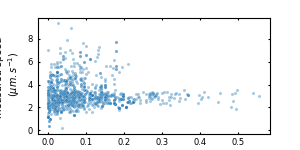

In [23]:
fig,ax = plt.subplots(figsize=(3, 1.5))
select = merged_df[merged_df['mappingBF']<10]

select = select[select['coverage_totBF'] >= 0.1]
sns.scatterplot(data=select, x="speed_estimated", y="speed_real", s=5, alpha=0.4, ax=ax)
ax.set_ylabel("measured speed \n ($\mu m.s^{-1}$)")
ax.set_xlabel("growth induced speed ($\mu m.s^{-1}$)")
plt.savefig(
    os.path.join(path_figure, "heaton_model.pdf"),
    transparent=True,
    bbox_inches="tight",
)


In [24]:
G = spatial_temporal_graph_sub
densities = [abs(G[u][v]['speed_heaton_42'])*C_factor_flux*100 for u, v in G.edges() if G[u][v]['hyperedge']==3169 and G[u][v]['post_hyperedge_activation']<=37]
xs = [40000-abs(G[u][v]['x']) for u, v in G.edges() if G[u][v]['hyperedge']==3169  and G[u][v]['post_hyperedge_activation']<=37]

fig,ax = plt.subplots(figsize=(3, 1))
ax.scatter(xs,densities)
ax.set_xlabel("curvilinear coordinate ($\mu m$)")
ax.set_ylabel(r"$\rho_C$ (%)")
plt.savefig(
    os.path.join(path_figure, "densities_profile.pdf"),
    transparent=True,
    bbox_inches="tight",
)


KeyError: 'x'